# 1. What is Machine Learning / AI ?
Instead of coding a program with specific instructions, the goal of machine learning/AI is to "train" an algorithm so it can make predictions for itself. 

### Example: Snapchat filter
In a Snapchat, or other apps you can download on a phone, you can select filters like "bunny ears" or "sunglasses".

![image](./snapchat.png)
(source: https://www.flickr.com/photos/63405864@N04/27265562262)

When you have the filter on, the sunglasses are (most of the time) in the right spot. How does it know how to do that if the program has never seen your face before? There are two main steps involved that the developers do:
1. Train an AI model to predict the location of eyes/ears from a big, labelled dataset of human faces.
2. When running on your phone. The same model predicts where your eyes are, and a separate function will put an image of sunglasses over that location on your face.

### Example: Avatar livestream
The same technique can be used to create a live avatar of YOU!
https://pose-animator-demo.firebaseapp.com/camera.html
On this webpage, with your webcam enabled, you will see a live video stream of yourself, and an cartoon avatar that will move when you move, and make the same faces you make.

!!! Will not work if you are using your webcam on Zoom or another application !!! 


# 2. AI in Healthcare
In addition to a lot of the cool looking demo's out there. There are a lot of applications of AI that have the potential to make huge, positive impacts on our communitys. One of those applications is in the healthcare industry. By looking at patient images (could be X-Ray, brain MRI, lung CT), we can potentially train AI models to make predictions about whether patients are at risk for disease, and speed up their interactions with doctors, clinicians when they are high-risk.

One interesting body part that tells us a lot of information about a person's health is the eye. There are a lot of diseases that can be detected early on, when looking at images of the eye. On top of vision-related issues like near-sightedness, with different kinds of images of the eye, doctors are able to diagnose diabetes, heart conditions, alzheimers (in some cases) when these diseases are at early stages.

## Example: Looking at the retina with an OCT eye scan.
The retina is a part of your the back of your eye:

![retina](retina.png)
(source: https://en.wikipedia.org/wiki/Retina#/media/File:Three_Main_Layers_of_the_Eye.png)

By using a imaging technique called OCT (Optical Coherence Tomography), we can compute an image similar to the one below that visualizes the retina, fovea, and other regions usefull for disease diagnosis. This is what a healthy, normal oct looks like. We will see images of what unhealthy eyes look like when we open up our dataset further on.

![oct image](oct_normal.png)
(source: https://commons.wikimedia.org/wiki/File:SD-OCT_Macula_Cross-Section.png)

In practice, doctors look at these OCT images when trying to disagnose retinal diseases, and guide treatment for their patients. 


# 3. Can we train an AI model to predict different disease types from an eye scan?
That is our goal for today! Our task is to build an AI model and train it to predict whether a patient's eye is healthy, or shows characteristics of one of the following diseases:
1. healthy
2. Diabetic Macular Edema (DME) - patient has fluid in the retinal layers of the eye. A sign of diabetes.
2. Choroidal neovascularization (CNV) - patient has blood veins growing in between retinal layers. Patient will have vision loss.
3. Drusen - "tiny pebbles of debris" are visible in the retinal layers. These debris are made of fat molecules.

Today we will cover the complete cycle of training an AI model including:
1. Loading and visualizing the data
2. Building the AI model
3. Training the AI model
4. Visualizing the AI model.


# Let's Start Coding!

## 1. Download OCT2017 dataset
This will download the dataset to the location this code runs in. *It will not download it to your computer*

In [ ]:
# Download dataset
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/5699a1d8-d1b6-45db-bb92-b61051445347/OCT2017.tar.gz

# Decompress dataset
!tar -zxf OCT2017.tar.gz

## 2. Setup Programming Environment
In industry, we never start from scratch. We use tools that make it easier to load data, build AI models, and train and visualize them. Let's make sure these tools are in our coding environment!

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import VGG16, DenseNet121, InceptionV3, InceptionResNetV2, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

MODEL_BANK = {
    'VGG16': VGG16,
    'DenseNet121': DenseNet121,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'ResNet50': ResNet50
}

## 3. Preprocess dataset
Here we will setup the code that will iterate through the dataset

In [22]:
batch_size = 32   # what happens when this increases/decreases?
img_size = 224
input_img_size = (224,224,3)
class_labels_short = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_labels_long = ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


###############################################
# Training Data
train_data_preprocessing = ImageDataGenerator(
      brightness_range=None, 
      shear_range=0.0,        # try changing me!
      zoom_range=0.0,         # try changing my value!
      horizontal_flip=False,  # try setting me to True
      vertical_flip=False,    # try setting me to True
      rescale=None, 
      preprocessing_function=preprocess_input,
      data_format=None, 
      validation_split=0.2)

train_data = train_data_preprocessing.flow_from_directory(
    'OCT2017/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    shuffle=True,
    subset='training',
    batch_size=batch_size)

validation_data = train_data_preprocessing.flow_from_directory(
    'OCT2017/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    shuffle=True,
    subset='validation',
    batch_size=batch_size)

###############################################
# Testing Data
test_data_preprocessing = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_data = test_data_preprocessing.flow_from_directory(
                'OCT2017/test',
                target_size=(img_size, img_size),
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size)

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


<Figure size 432x288 with 0 Axes>

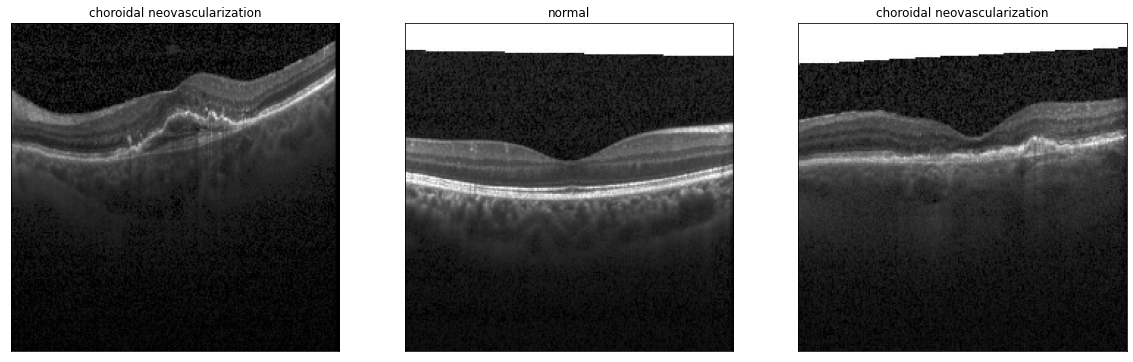

<Figure size 432x288 with 0 Axes>

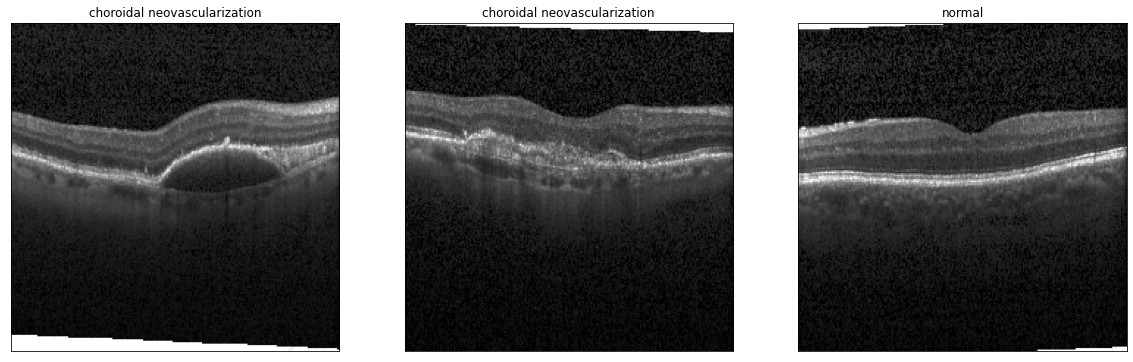

<Figure size 432x288 with 0 Axes>

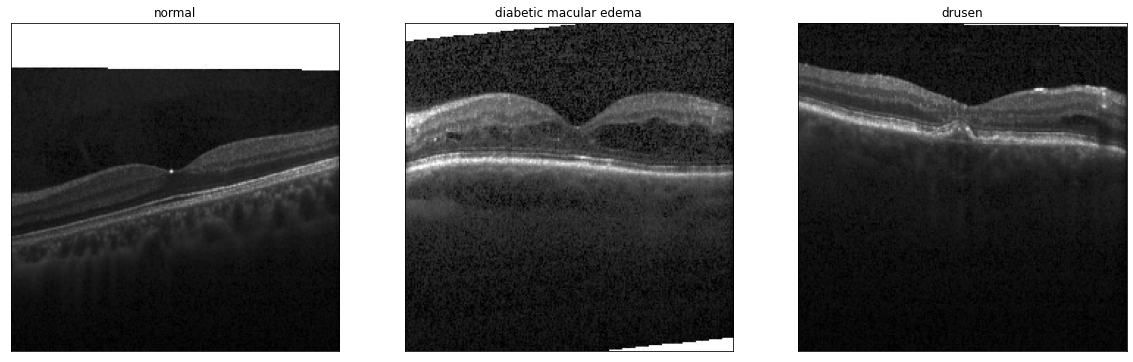

<Figure size 432x288 with 0 Axes>

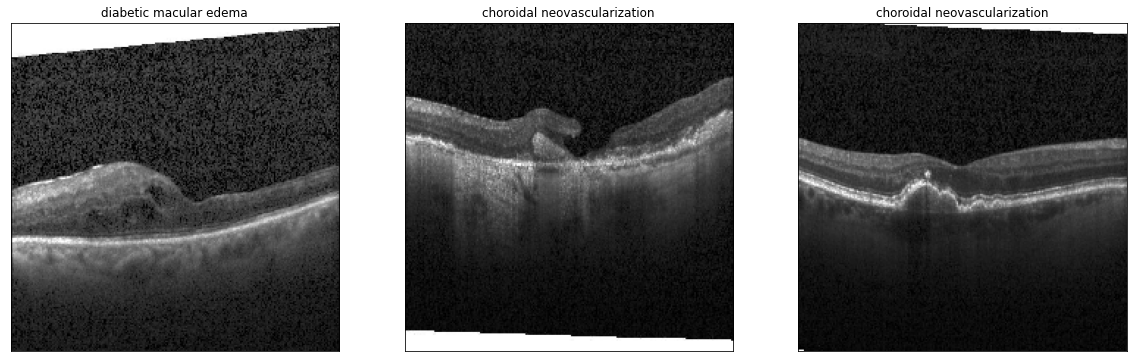

<Figure size 432x288 with 0 Axes>

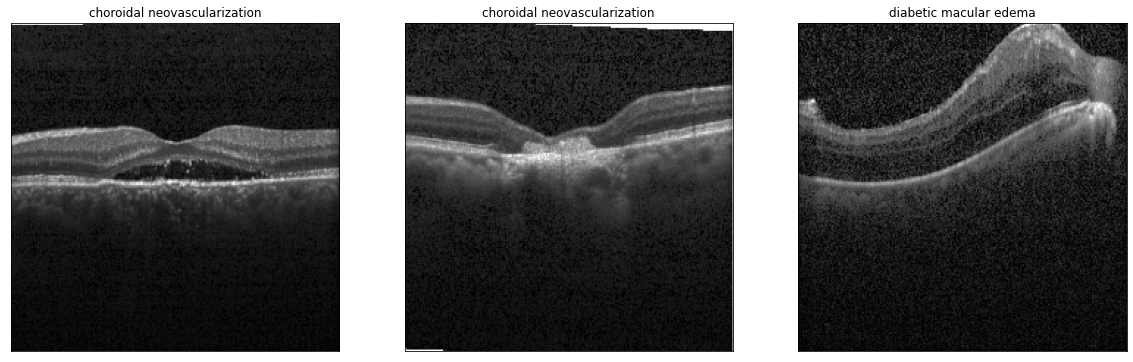

In [23]:
def plot_some_images(train_iter, nb_image_rows=15, nb_images_per_row=3):
    nb_images_per_row = 3
    train_iter.batch_size=nb_images_per_row
    for i in range(nb_image_rows):
        x_batch, y_batch = train_iter.next()
        x_batch += 1
        x_batch /= 2

        plt.figure()
        fig, axes =  plt.subplots(nrows=1, ncols=nb_images_per_row, figsize=(20,15))
        for ax, x, y in zip(axes, x_batch, y_batch):
            ax.imshow(x)
            ax.set_title(class_labels_long[np.argmax(y)])
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()
    
plot_some_images(validation_data, nb_image_rows=5)

## 4. Build AI model
An AI model consists of multiple layers. The input layer is connected to the input images. The middle layers perform several, sequental computations on the data. And the final, output layer will predict which class the model thinks the image belongs to.

In [ ]:
num_classes = 4

# a function to help us build the model
def build_model(base_model_name='VGG16', freeze_base=False):
    assert base_model_name in MODEL_BANK.keys(), f'model name be one of {MODEL_BANK.keys()}, you entered {model_name} '
    base_model = MODEL_BANK[base_model_name](
                    weights='imagenet',
                    input_shape=input_img_size,
                    include_top=False)
    for layer in base_model.layers:
        if freeze_base:
            layer.trainable = False
        else:
            layer.trainable = True
        
    x = base_model.layers[-3].output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    
    return model

"""
Below, we call the function above with a particular base-model name. 
We can also try using a different base model name:
   * VGG16, DenseNet121, InceptionV3,  InceptionResNetV2, ResNet50
What happens if we set freeze_base=True?
"""
oct_model = build_model(base_model_name='VGG16', freeze_base=False)
oct_model.summary()

## 5. Train Model
In the code below, we train the model using the data we visualized above. We can play around with some parameters here:
* learning_rate - a number that controls fast or slow the model learns. If we set it too low, the model will learn very slowly, and we'll be waiting a long time for the model to get a good accuracy. If we set it too high, the model will get confused from trying to learn too quickly! 
* n_epochs - the number of times to iterate through the entire dataset. For now anywhere between 1-5 is a good choice.
* n_steps_per_epoch - When we train the model, we show it a few examples at a time. This number controls how many batches of data we show the model, before deciding to stop and make a new epoch.

In [ ]:
# hyperparameters. What happens when we change these values
learning_rate = 0.0001 # what happens if we decrease this?
n_epochs = 1
n_train_steps_per_epoch = 500 # entire dataset = 66788 // batch_size 
n_valid_steps_per_epoch = 100 # entire valid set = 16696 // batch_size

# Save checkpoint
weights_name = "weights.h5"
weight_saver = ModelCheckpoint(
    weights_name, 
    monitor="val_acc", 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True)

# Optimizer
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
oct_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Train the model!!
trained_oct_model = oct_model.fit(
    train_data,
    epochs=n_epochs,
    steps_per_epoch=n_train_steps_per_epoch,
    validation_data=validation_data,
    validation_steps=n_valid_steps_per_epoch,
    callbacks=[weight_saver])

## 6. Summarize Accuracy
Let's visualize how our model got better over time.

In [ ]:
plt.plot(list(range(n_epochs)), trained_oct_model.history['val_acc'], label='validation accuracy')
plt.plot(list(range(n_epochs)), trained_oct_model.history['acc'], label='training accuracy')
                                                        
plt.ylim(bottom=0)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(loc='lower right')   
plt.show()

## 7. Label Heat Map
Below are some helper functions to visualize where the model was looking in the image when it made it's predictions. Let's not change any of this code.

In [21]:
CAM = oct_model
def get_heatmap(image_class, preprocessed_image):
    feature_weight = CAM.layers[-1].get_weights()[0]
    features_map = CAM.layers[-4]

    output = tf.keras.backend.function(
        [CAM.layers[0].input], 
        [features_map.output, CAM.layers[-1].output])

    [raw_output, _] = output(preprocessed_image)
    raw_output = raw_output[0, :, :, :]

    cam = np.zeros(dtype=np.float32, shape=raw_output.shape[0:2])

    for index, weight in enumerate(feature_weight[:, image_class]):
        cam += weight * raw_output[:, :, index]


    cam /= np.max(cam)
    cam = cv2.resize(cam, (img_size, img_size))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) 
    heatmap[np.where(cam < 0)] = 0
    
    return heatmap

def heat_map(image_path, image_class):        
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224,224))

    preprocessed_image = preprocess_input(img)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

    heatmap = get_heatmap(image_class, preprocessed_image)

    result = cv2.addWeighted(img, 1, heatmap, 0.4, 0)
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 3, figsize=(13, 13))
    
    ax[0].imshow(img)
    ax[0].axis('off')
    
    ax[1].imshow(heatmap)
    ax[1].axis('off')
    
    ax[2].imshow(result)
    ax[2].axis('off')

In [ ]:
cnv_path = "OCT2017/test/CNV"              # 0
dme_path = "OCT2017/test/DME"              # 1  
drusen_path = "OCT2017/test/DRUSEN"        # 2
normal_path = "OCT2017/test/NORMAL"        # 3

In [ ]:
import cv2
import os

oct_model.load_weights('weights.h5')

# Change index for testing new image (0 =< index =< 999)
index = 0

for i in range(num_classes):
    plt.figure(i)    
    
    if i == 0:
        path = cnv_path + '/' + os.listdir(cnv_path)[index]
    elif i == 1:
        path = dme_path + '/' + os.listdir(dme_path)[index]
    elif i == 2:
        path = drusen_path + '/' + os.listdir(drusen_path)[index]
    else:
        path = normal_path + '/' + os.listdir(normal_path)[index]

    heat_map(path, i)